# Introduction to NLP Fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (could be sequences text or speech)

Another common term for NLP problems is sequence to sequence problems (seq2seq)

To get hands-on with NLP in TensorFlow, we're going to practice the steps we've used previously but this time with text data:

```
Text -> turn into numbers -> build a model -> train the model to find patterns -> use patterns (make predictions)
```

## Get helper functions

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions 
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2021-10-07 21:23:34--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-10-07 21:23:34 (63.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a text dataset

The dataset we're going to be using is [`Kaggle's intorduction to NLP dataset`](https://www.kaggle.com/c/nlp-getting-started/data) (text samples of Tweets labelled as disaster or not disaster)

In [2]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
unzip_data("nlp_getting_started.zip")

--2021-10-07 21:23:42--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.251.2.128, 74.125.137.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2021-10-07 21:23:42 (125 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



Unzipping `nlp_getting_started.zip` gives the following 3 `.csv` files:
* `sample_submission.csv` - an example of the file you'd submit to the Kaggle competition of your model's predictions.
* `train.csv` - training samples of real and not real diaster Tweets.
* `test.csv` - testing samples of real and not real diaster Tweets.

## Visualizing a text dataset

To visualize our text samples, we first have to read them in, one way to do so would be to use Python.

But another way to do this is to use Pandas

In [3]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


Notice how the training data has a `"target"` column.

We're going to be writing code to find patterns (e.g. different combinations of words) in the `"text"` column of the training dataset to predict the value of the `"target"` column.

The test dataset doesn't have a `"target"` column.

```
Inputs (text column) -> Machine Learning Algorithm -> Outputs (target column)
```

*Example text classification inputs and outputs for the problem of classifying whether a Tweet is about a diaster or not.*

In [5]:
# What does the test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

Since we have two target values, we're dealing with a **binary classification** problem.

It's fairly balanced too, about 60% negative class (`target = 0`) and 40% positive class (`target = 1`).

Where, 

* `1` = a real disaster Tweet
* `0` = not a real disaster Tweet

In [7]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [8]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: 1 (real disaster)
Text:
@AisuMage @AkumaReisu --just between Gray and Ophelia red flames blazing around her person setting nearly everything in the area--

-----

Target: 0 (not real disaster)
Text:
Talk on GOZ is fantastic. Most interesting fact so far is that they manually bought all the .ru domains to sinkhole rather than seek co-op.

-----

Target: 0 (not real disaster)
Text:
WOOOOOOO RT @GameRant: Call of Duty: Black Ops 3 eSports Mode Lets Players Ban Weapons http://t.co/76EHHmQQ6R http://t.co/umtffA9JjB

-----

Target: 1 (real disaster)
Text:
Strong Thunderstorm 4 Miles North of Japton Moving SE At 25 MPH. Large Hail and Wind Gusts Up to 50 MPH Poss... #arwx http://t.co/TIM8x9bI0f

-----

Target: 0 (not real disaster)
Text:
I liked a @YouTube video http://t.co/TNXQuOr1wb Kalle Mattson - 'Avalanche' (Official Video)

-----



### Split data into training and validation sets

In [5]:
# Use train_test_split to split training data into training and validation sets
from sklearn.model_selection import train_test_split
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42) # use 10% of the data for validation split

In [10]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [11]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Converting text into numbers

When dealing with a text problem, one of the first things you'll have to do before you build a model is to convert your text to numbers

In NLP, there are two main concepts for turning text into numbers:
* **Tokenization** - A straight mapping from word or character or sub-word to a numerical value. There are three main levels of tokenization:
  1. Using **word-level tokenization** with the sentence "I love TensorFlow" might result in "I" being `0`, "love" being `1` and "TensorFlow" being `2`. In this case, every word in a sequence considered a single **token**.
  2. **Character-level tokenization**, such as converting the letters A-Z to values `1-26`. In this case, every character in a sequence considered a single **token**.
  3. **Sub-word tokenization** is in between word-level and character-level tokenization. It involves breaking invidual words into smaller parts and then converting those smaller parts into numbers. For example, "my favourite food is pineapple pizza" might become "my, fav, avour, rite, fo, oo, od, is, pin, ine, app, le, piz, za". After doing this, these sub-words would then be mapped to a numerical value. In this case, every word could be considered multiple **tokens**.
* **Embeddings** - An embedding is a representation of natural language which can be learned. Representation comes in the form of a **feature vector**. For example, the word "dance" could be represented by the 5-dimensional vector `[-0.8547, 0.4559, -0.3332, 0.9877, 0.1112]`. It's important to note here, the size of the feature vector is tuneable. There are two ways to use embeddings: 
  1. **Create your own embedding** - Once your text has been turned into numbers (required for an embedding), you can put them through an embedding layer (such as [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)) and an embedding representation will be learned during model training.
  2. **Reuse a pre-learned embedding** - Many pre-trained embeddings exist online. These pre-trained embeddings have often been learned on large corpuses of text (such as all of Wikipedia) and thus have a good underlying representation of natural language. You can use a pre-trained embedding to initialize your model and fine-tune it to your own specific task.

> 🤔 **Question:** What level of tokenzation should I use? What embedding should should I choose?

It depends on your problem. You could try character-level tokenization/embeddings and word-level tokenization/embeddings and see which perform best. You might even want to try stacking them (e.g. combining the outputs of your embedding layers using [`tf.keras.layers.concatenate`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/concatenate)). 

If you're looking for pre-trained word embeddings, [Word2vec embeddings](http://jalammar.github.io/illustrated-word2vec/), [GloVe embeddings](https://nlp.stanford.edu/projects/glove/) and many of the options available on [TensorFlow Hub](https://tfhub.dev/s?module-type=text-embedding) are great places to start.

> 🔑 **Note:** Much like searching for a pre-trained computer vision model, you can search for pre-trained word embeddings to use for your problem. Try searching for something like "use pre-trained word embeddings in TensorFlow".

### Text Vectorization (tokenization)

The `TextVectorization` layer takes the following parameters:
* `max_tokens` - The maximum number of words in your vocabulary (e.g. 20000 or the number of unique words in your text), includes a value for OOV (out of vocabulary) tokens. 
* `standardize` - Method for standardizing text. Default is `"lower_and_strip_punctuation"` which lowers text and removes all punctuation marks.
* `split` - How to split text, default is `"whitespace"` which splits on spaces.
* `ngrams` - How many words to contain per token split, for example, `ngrams=2` splits tokens into continuous sequences of 2.
* `output_mode` -  How to output tokens, can be `"int"` (integer mapping), `"binary"` (one-hot encoding), `"count"` or `"tf-idf"`. See documentation for more.
* `output_sequence_length` - Length of tokenized sequence to output. For example, if `output_sequence_length=150`, all tokenized sequences will be 150 tokens long.
* `pad_to_max_tokens` - Defaults to `False`, if `True`, the output feature axis will be padded to `max_tokens` even if the number of unique tokens in the vocabulary is less than `max_tokens`. Only valid in certain modes, see docs for more.

In [12]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# DEMONSTRATING the DEFAULT TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, # defines how many words in the vocabulary (automatically add <OOV>)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) # how long do you want your output sequences to be
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

We've initialized a `TextVectorization` object with the default settings but let's customize it a little bit for our own use case.

In particular, let's set values for `max_tokens` and `output_sequence_length`.

For `max_tokens` (the number of words in the vocabulary), multiples of 10,000 (`10,000`, `20,000`, `30,000`) or the exact number of unique words in your text (e.g. `32,179`) are common values.

For our use case, we'll use `10,000`.

And for the `output_sequence_length` we'll use the average number of tokens per Tweet in the training set. But first, we'll need to find it.

In [14]:
# Find the average number of tokens (words) in the training tweets
round(sum(len(i.split()) for i in train_sentences)/len(train_sentences))

15

In [15]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a tweet does our model see)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

To map our `TextVectorization` instance `text_vectorizer` to our data, we can call the `adapt()` method on it whilst passing it our training text.

In [9]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [11]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a mug on the table!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 6), dtype=int64, numpy=array([[ 264,    3,    1,   11,    2, 2663]])>

In [18]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
        \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
 'The Reagan Administration had arranged for Israeli weapons to be sent to the Guatemalan Army  http://t.co/4fYNQ1hWWb        

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   2, 9317, 6263,   94,    1,   10,  602,  258,    5,   21, 1596,
           5,    2,    1,  164]])>

We can check the unique tokens in our vocabulary using the `get_vocabulary()` method.

In [19]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in our training data
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words in vocab: {top_5_words}")
print(f"5 least common words in vocab: {bottom_5_words}")

Number of words in vocab: 10000
5 most common words in vocab: ['', '[UNK]', 'the', 'a', 'in']
5 least common words in vocab: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer

The powerful thing about an embedding is it can be learned during training. This means rather than just being static (e.g. `1` = I, `2` = love, `3` = TensorFlow), a word's numeric representation can be improved as a model goes through data samples.

The main parameters we're concerned about here are:
* `input_dim` - The size of the vocabulary (e.g. `len(text_vectorizer.get_vocabulary()`).
* `output_dim` - The size of the output embedding vector, for example, a value of `100` outputs a  feature vector of size 100 for each word. (each token gets represented bu a vector 100 long)
* `embeddings_initializer` - How to initialize the embeddings matrix, default is `"uniform"` which randomly initalizes embedding matrix with uniform distribution. This can be changed for using pre-learned embeddings.
* `input_length` - Length of sequences being passed to embedding layer.

In [20]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # size of the embedding vector
                             embeddings_initializer="uniform", # default, initialize randomly
                             input_length=max_length) # how long is each input

embedding

Notice how `embedding` is a TensoFlow layer? This is important because we can use it as part of a model, meaning its parameters (word representations) can be updated and improved as the model learns.

In [21]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 Man . somebody gotta stop Sbee dude too fuckin funny blood      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.04461151,  0.03961584,  0.02465744, ..., -0.01866372,
         -0.00841191,  0.04245517],
        [ 0.01754216, -0.00119487, -0.01312176, ..., -0.04464993,
          0.02956721, -0.02847507],
        [ 0.04386619,  0.02840788,  0.00240091, ...,  0.00849953,
         -0.03618901,  0.01962293],
        ...,
        [-0.0012532 ,  0.03716965,  0.00968367, ...,  0.04133293,
          0.03937745,  0.01071076],
        [-0.0012532 ,  0.03716965,  0.00968367, ...,  0.04133293,
          0.03937745,  0.01071076],
        [-0.0012532 ,  0.03716965,  0.00968367, ...,  0.04133293,
          0.03937745,  0.01071076]]], dtype=float32)>

Each token in the sentence gets turned into a length 128 feature vector.

In [22]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.04461151,  0.03961584,  0.02465744, -0.0457072 , -0.04604244,
         0.0280154 , -0.03256259,  0.0141517 , -0.0045867 ,  0.01385221,
        -0.01586212, -0.02253008, -0.01424081, -0.03278085, -0.01775406,
         0.03185748, -0.02805494, -0.04060543,  0.00571389,  0.049997  ,
        -0.01382437, -0.01721781,  0.02588366,  0.00428043,  0.00461042,
         0.008045  , -0.00329085, -0.03441088,  0.01807323, -0.02745605,
         0.02515955, -0.01643424,  0.02236005, -0.03658252,  0.04625135,
        -0.02974608, -0.03771418,  0.0090288 , -0.02496538,  0.01323644,
         0.03128991, -0.01619508, -0.03048185,  0.0221761 ,  0.04117687,
         0.04873708,  0.03659612,  0.0299519 , -0.04769072,  0.02699271,
         0.02555659, -0.04864026,  0.03403797, -0.00864235,  0.04029295,
         0.04197798, -0.02318193,  0.02296982,  0.00574613, -0.00595979,
         0.00151181, -0.0156226 , -0.04322232, -0.01174948, -0.03198489,
  

## Modelling a text dataset (running series of experiments)

Now we've got way to turn our text sequences into numbes, it's time to start building a series of modelling experiments.

We'll start with a baseline and move on from there.

* **Model 0**: Naive Bayes (baseline)
* **Model 1**: Feed-forward neural network (dense model)
* **Model 2**: LSTM model (RNN)
* **Model 3**: GRU model (RNN)
* **Model 4**: Bidirectional-LSTM model (RNN)
* **Model 5**: 1D Convolutional Neural Network (CNN)
* **Model 6**: TensorFlow Hub Pretrained Feature Extractor (using transfer learning for NLP)
* **Model 7**: Same as model 6 with 10% of training data

Model 0 is the simplest to acquire a baseline which we'll expect each other of the other deeper models to beat.

Each experiment will go through the following steps:
* Create a model
* Build a model
* Fit a model
* Evaluate our model

### Model 0: Getting a baseline

As with all machine learning modelling experiments, it's important to create a baseline model wo you've got a benchmark for future experiments to build up on.

To create our baseline, we'll create a Scikit-Learn Pipeline using the TF-IDF (term frequency-inverse document frequency) formula to convert our words to numbers and then model them with the [Multinomial Naive Bayes algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB). This was chosen via referring to the [Scikit-Learn machine learning map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).

>🔑 **Note:** It's common practice to use non-DL algorithms as a baseline because of their speed and then later using DL to see if you can improve upon them.

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
  ("tfidf", TfidfVectorizer()), # Convert words to numbers using tfidf
  ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

The benefit of using a shallow model like Multinomial Naive Bayes is that training is very fast.

In [31]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)

baseline_score

0.7926509186351706

In [32]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:10]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0])

### Creating an evaluation function for our model experiments

We could evaluate these as they are but since we're going to be evaluating several models in the same way going forward, let's create a helper function which takes an array of predictions and ground truth labels and computes the following:
* Accuracy
* Precision
* Recall
* F1-score

> 🔑 **Note:** Since we're dealing with a classification problem, the above metrics are the most appropriate. If we were working with a regression problem, other metrics such as MAE (mean absolute error) would be a better choice.

📖 For a deep overview of many different evaluation methods, see the Sklearn documentation: https://scikit-learn.org/stable/modules/model_evaluation.html

In [35]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1-score using *weighted* average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}

  return model_results

In [39]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 1: A simple dense model

It'll take our text and labels as input, tokenize the text, create an embedding, find the average of the embedding (using Global Average Pooling) and then pass the average through a fully connected layer with one output unit and a sigmoid activation function.

In [28]:
# Create a tensorboard callback (need to create a nwe one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [29]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional string
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token to one vector (lower the dimensionality of the embedding)
outputs = layers.Dense(1, activation="sigmoid")(x) # Create the output layer, want binary outputs so used sigmoid
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

Our model takes a 1-dimensional string as input (in our case, a Tweet), it then tokenizes the string using `text_vectorizer` and creates an embedding using `embedding`.

We then  pool the outputs of the embedding layer to reduce the dimensionality of the tensor we pass to the output layer.

Finally, we pass the output of the pooling layer to a dense layer with sigmoid activation (we use sigmoid since our problem is binary classification).

In [30]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


Most of the trainable parameters are contained within the embedding layer. Recall we created an embedding of size 128 (`output_dim=128`) for a vocabulary of size 10,000 (`input_dim=10000`), hence the 1,280,000 trainable parameters.

In [31]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

# Fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20211007-102629
Epoch 1/5
215/215 [==============================] - 5s 9ms/step - loss: 0.6102 - accuracy: 0.6865 - val_loss: 0.5349 - val_accuracy: 0.7533
Epoch 2/5
215/215 [==============================] - 2s 7ms/step - loss: 0.4399 - accuracy: 0.8212 - val_loss: 0.4704 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 2s 7ms/step - loss: 0.3453 - accuracy: 0.8606 - val_loss: 0.4573 - val_accuracy: 0.7861
Epoch 4/5
215/215 [==============================] - 1s 7ms/step - loss: 0.2829 - accuracy: 0.8913 - val_loss: 0.4588 - val_accuracy: 0.7900
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.2363 - accuracy: 0.9118 - val_loss: 0.4760 - val_accuracy: 0.7874


In [32]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.4760 - accuracy: 0.7874


[0.4759829044342041, 0.787401556968689]

In [33]:
# Make some predictions and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

(762, 1)

In [34]:
# Look at a single prediction
model_1_pred_probs[0]

array([0.40028867], dtype=float32)

In [35]:
# Look at the first 10 predictions
model_1_pred_probs[:10]

array([[0.40028867],
       [0.800866  ],
       [0.9978104 ],
       [0.10491349],
       [0.10441678],
       [0.93273485],
       [0.9109768 ],
       [0.9928678 ],
       [0.9658808 ],
       [0.24589317]], dtype=float32)

In [36]:
# Convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))

In [37]:
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [38]:
# Calculate our model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.74015748031496,
 'f1': 0.7845557264291478,
 'precision': 0.791897156051696,
 'recall': 0.7874015748031497}

In [39]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [40]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

Looks like our baseline is out performing our first deep learning model

Since we'll be doing this kind of comparison (baseline compared to new model) quite a few times, let's create a function to help us out. 

In [41]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results, 
                                new_model_results=model_1_results)

Baseline accuracy: 79.27, New accuracy: 78.74, Difference: -0.52
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.79, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.00


## Visualizing learned embeddings

Our first model (`model_1`) contained an embedding layer (`embedding`) which learned a way of representing words as feature vectors by passing over the training data.

In [42]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [43]:
max_vocab_length

10000

In [44]:
# Model_1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [45]:
# Get the weight matrix of embedding layer
# (these are the numerical represenatation of each token in our training data, which have been learned for 5 epochs)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
embed_weights.shape #should be same size as vocab size and embedding_dim (output_dim of our embedding layer)

(10000, 128)

Now we've got the embedding matrix our model has learned to represent our tokens, let's see how we can visualize it

To do so, TensorFlow has a handy tool called projector: https://projector.tensorflow.org/

And TensorFlow also has an incredible guide on word embeddings themselves: https://www.tensorflow.org/text/guide/word_embeddings

In [46]:
# Create embedding files (we got this from TensorFlow's word embeddings documentation)
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [47]:
# Download files from Colab to upload to Projector
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

https://projector.tensorflow.org/

📖 **Resources:**
 - [TensorFlow's Word Embeddings guide](https://www.tensorflow.org/text/guide/word_embeddings#representing_text_as_numbers)
 - [Jay Alammar's visualized word2vec post](https://jalammar.github.io/illustrated-word2vec/)

## Recurrent Neural Networks (RNN's)

RNN's are useful for sequence data

The premise of an RNN is simple: use information from the past to help you with the future (this is where the term recurrent comes from). In other words, take an input (`X`) and compute an output (`y`) based on all previous inputs.

This concept is especially helpful when dealing with sequences such as passages of natural language text (such as our Tweets).

For example, when you read this sentence, you take into context the previous words when deciphering the meaning of the current word dog. 

See what happened there? 

I put the word "dog" at the end which is a valid word but it doesn't make sense in the context of the rest of the sentence.

When an RNN looks at a sequence of text (already in numerical form), the patterns it learns are continually updated based on the order of the sequence. 

For a simple example, take two sentences:
1. Massive earthquake last week, no?
2. No massive earthquake last week.

Both contain exactly the same words but have different meaning. The order of the words determines the meaning (one could argue punctuation marks also dictate the meaning but for simplicity sake, let's stay focused on the words).

Recurrent neural networks can be used for a number of sequence-based problems:
* **One to one:** one input, one output, such as image classification.
* **One to many:** one input, many outputs, such as image captioning (image input, a sequence of text as caption output).
* **Many to one:** many inputs, one outputs, such as text classification (classifying a Tweet as real diaster or not real diaster).
* **Many to many:** many inputs, many outputs, such as machine translation (translating English to Spanish) or speech to text (audio wave as input, text as output).

When you come across RNN's in the wild, you'll most likely come across variants of the following:
* Long short-term memory cells (LSTMs).
* Gated recurrent units (GRUs).
* Bidirectional RNN's (passes forward and backward along a sequence, left to right and right to left).

> 📖 **Resources:**
> * [MIT Deep Learning Lecture on Recurrent Neural Networks](https://youtu.be/SEnXr6v2ifU) - explains the background of recurrent neural networks and introduces LSTMs.
> * [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) by Andrej Karpathy - demonstrates the power of RNN's with examples generating various sequences.
> * [Understanding LSTMs](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) by Chris Olah - an in-depth (and technical) look at the mechanics of the LSTM cell, possibly the most popular RNN building block.

### Model 2: LSTM

LSTM = Long short term memory (one of the most popular LSTM cells)

Our structure of an RNN typically looks like this:

```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (label probability
```

> 🔑 **Note:** The reason we use a new embedding layer for each model is since the embedding layer is a *learned* representation of words (as numbers), if we were to use the same embedding layer (`embedding_1`) for each model, we'd be mixing what one model learned with the next. And because we want to compare our models later on, starting them with their own embedding layer each time is a better idea.

In [48]:
# Create an embedding layer (new embedding layer for each model)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")
# Create LSTM model 
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
#print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # when you're stacking RNN cells together, you need to set return_sequences=True
#print(x.shape)
x = layers.LSTM(64)(x)
#print(x.shape)
#x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [49]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 15, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

In [51]:
# Fit the model
model_2_history = model_2.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20211007-102653
Epoch 1/5
215/215 [==============================] - 8s 15ms/step - loss: 0.5087 - accuracy: 0.7453 - val_loss: 0.4605 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3130 - accuracy: 0.8724 - val_loss: 0.5130 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2163 - accuracy: 0.9187 - val_loss: 0.5743 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1506 - accuracy: 0.9461 - val_loss: 0.6909 - val_accuracy: 0.7612
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1087 - accuracy: 0.9590 - val_loss: 0.8054 - val_accuracy: 0.7572


In [52]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

array([[0.01293849],
       [0.83402115],
       [0.9996407 ],
       [0.02915895],
       [0.00839933],
       [0.9996313 ],
       [0.87252724],
       [0.99984205],
       [0.99966574],
       [0.17700982]], dtype=float32)

In [53]:
# Convert model_2 pred_probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [54]:
# Calculate model 2 results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 75.7217847769029,
 'f1': 0.7543632423639389,
 'precision': 0.7596733982700739,
 'recall': 0.7572178477690289}

In [55]:
# Compare model 2 to baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 79.27, New accuracy: 75.72, Difference: -3.54
Baseline precision: 0.81, New precision: 0.76, Difference: -0.05
Baseline recall: 0.79, New recall: 0.76, Difference: -0.04
Baseline f1: 0.79, New f1: 0.75, Difference: -0.03


### Model 3: GRU

Another popular and effective RNN component is the GRU of gated recurrent unit.


The GRU cell has similar features to an LSTM cell but has less parameters

> 📖 **Resource:** A full explanation of the GRU cell is beyond the scope of this noteook but I'd suggest the following resources to learn more:
* [Gated Recurrent Unit](https://en.wikipedia.org/wiki/Gated_recurrent_unit) Wikipedia page
* [Understanding GRU networks](https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be) by Simeon Kostadinov

To use the GRU cell in TensorFlow, we can call the [`tensorflow.keras.layers.GRU()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) class.

The architecture of the GRU-powered model will follow the same structure we've been using:

```
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
```

In [56]:
# Create embedding layer
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")
# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = model_3_embedding(x)
#x = layers.GRU(64, return_sequences=True)(x) # if you want to stack recurrent layers on top of each other, you need to set return_sequences=True
#x = layers.GlobalAveragePooling1D()(x)
x = layers.GRU(64)(x)
print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

(None, 64)


In [57]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 15, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 64)                37248     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________________________


Notice the difference in number of trainable parameters between `model_2` (LSTM) and `model_3` (GRU). The difference comes from the LSTM cell having more trainable parameters than the GRU cell.

> 🔑 **Note:** The return_sequences=True must be set if the next layer is an LSTM or a GRU since they need sequences in their input lists. But, if the next layer after an LSTM or a GRU is a Dense layer, return_sequences=False (or don't write anything because it is False as default) **BUT**, if you don't want to set it False, you need to add a GlobalAveragePooling1D layer to lower the dimension.

In [58]:
# Compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20211007-102717
Epoch 1/5
215/215 [==============================] - 5s 14ms/step - loss: 0.5362 - accuracy: 0.7259 - val_loss: 0.4547 - val_accuracy: 0.7913
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3173 - accuracy: 0.8689 - val_loss: 0.5016 - val_accuracy: 0.7927
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2189 - accuracy: 0.9188 - val_loss: 0.5325 - val_accuracy: 0.7822
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1605 - accuracy: 0.9426 - val_loss: 0.5812 - val_accuracy: 0.7835
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1198 - accuracy: 0.9610 - val_loss: 0.6795 - val_accuracy: 0.7703


In [59]:
# Make some predictions with our GRU model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

array([[0.25605994],
       [0.90098816],
       [0.9986003 ],
       [0.07926299],
       [0.00769992],
       [0.99643755],
       [0.620371  ],
       [0.99827266],
       [0.9986731 ],
       [0.37126163]], dtype=float32)

In [60]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [61]:
# Calculate model_3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 77.03412073490814,
 'f1': 0.7676409049388613,
 'precision': 0.7732589791209112,
 'recall': 0.7703412073490814}

In [62]:
# Compare model_3 to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.27, New accuracy: 77.03, Difference: -2.23
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


### Model 4: Bidirectional RNN

A standard RNN will process a sequence from left to right, where as a bidirectional RNN will process the sequence from left to right and then again from right to left.

Intuitively, this can be thought of as if you were reading a sentence for the first time in the normal fashion (left to right) but for some reason it didn't make sense so you traverse back through the words and go back over them again (right to left).

In practice, many sequence models often see an improvement in performance when using bidirectional RNN's.

However, this improvement in performance often comes at the cost of longer training times and increased model parameters (since the model goes left to right and right to left, the number of trainable parameters doubles).

We can use the `Bidirectional` class to wrap our existing RNNs, instantly making them bidirectional.

In [63]:
# Create an embedding layer for model_4
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a bidirectional RNN
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
print(x.shape)
#x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
#print(x.shape)
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

(None, 15, 128)
(None, 128)


> 🔑 **Note:** You can use the `Bidirectional` wrapper on any RNN cell in TensorFlow. For example, `layers.Bidirectional(layers.GRU(64))` creates a bidirectional GRU cell.

In [64]:
# Get a summary
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 15, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 1,378,945
Trainable params: 1,378,945
Non-trainable params: 0
_________________________________________________________________


Notice the increased number of trainable parameters in `model_4` (bidirectional LSTM) compared to `model_2` (regular LSTM). This is due to the bidirectionality we added to our RNN.

In [65]:
# Compile the model
model_4.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20211007-102732
Epoch 1/5
215/215 [==============================] - 8s 21ms/step - loss: 0.5127 - accuracy: 0.7497 - val_loss: 0.4563 - val_accuracy: 0.7887
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3070 - accuracy: 0.8759 - val_loss: 0.4687 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.2033 - accuracy: 0.9285 - val_loss: 0.5409 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.1380 - accuracy: 0.9526 - val_loss: 0.7430 - val_accuracy: 0.7533
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0981 - accuracy: 0.9656 - val_loss: 0.7541 - val_accuracy: 0.7612


Due to the bidirectionality of our model we see a slight increase in training time.

In [66]:
# Make predictions with the bidirectional model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

array([[0.10345738],
       [0.87129   ],
       [0.9994141 ],
       [0.03844122],
       [0.02280842],
       [0.99631953],
       [0.98248786],
       [0.9998838 ],
       [0.9997061 ],
       [0.12803969]], dtype=float32)

In [67]:
# Convert pred to probs to pred labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [68]:
# Calculate the results of our bidirectional model
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 76.11548556430446,
 'f1': 0.7589888106092002,
 'precision': 0.7625228137873495,
 'recall': 0.7611548556430446}

In [69]:
# Compare model_4 to baseline
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.27, New accuracy: 76.12, Difference: -3.15
Baseline precision: 0.81, New precision: 0.76, Difference: -0.05
Baseline recall: 0.79, New recall: 0.76, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.03


## Convolutional Neural Networks for Text (and other types of sequences)

You might've used convolutional neural networks (CNNs) for images before but they can also be used for sequences.

The main difference between using CNNs for images and sequences is the shape of the data. Images come in 2-dimensions (height x width) where as sequences are often 1-dimensional (a string of text).

So to use CNNs with sequences, we use a 1-dimensional convolution instead of a 2-dimensional convolution.

The typical structure of a Conv1D model for sequences (in our case, text):

```
Inputs(text) -> Tokenization -> Embedding -> Layer(s) (typicallt Conv1D + pooling) -> Outputs (class probabilities)
```

Instead of using an LSTM or GRU cell, we're going to use a [`tensorflow.keras.layers.Conv1D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) layer followed by a [`tensorflow.keras.layers.GlobablMaxPool1D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool1D) layer.

> 📖 **Resource:** The intuition here is explained succinctly in the paper [*Understanding Convolutional Neural Networks for Text Classification*](https://www.aclweb.org/anthology/W18-5408.pdf), where they state that CNNs classify text through the following steps:
1. 1-dimensional convolving filters are used as ngram detectors, each filter specializing in a closely-related family of ngrams (an ngram is a collection of n-words, for example, an ngram of 5 might result in "hello, my name is Daniel").
2. Max-pooling over time extracts the relevant ngrams for making a decision.
3. The rest of the network classifies the text based on this information.

## Model 5: Conv1D

Before we build a full 1-dimensional CNN model, let's see a 1-dimensional convolutional layer (also called a **temporal convolution**) in action.

We'll first create an embedding of a sample of text and experiment passing it through a `Conv1D()` layer and `GlobalMaxPool1D()` layer.

Difference between same and valid padding: https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t

In [70]:
#Create a new embedding layer and test out our Conv1D layer and max pooling
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")
embedding_test = model_5_embedding(text_vectorizer(["this is a test sentence"]))
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5, # this is also referred to as an ngram of 5 (meaning it looks at 5 words at a time)
                        strides=1, # default
                        activation="relu",
                        padding="same") #default is "valid", the output is smaller than the input shape, "same" means output is same
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 15, 32]), TensorShape([1, 32]))

Notice the output shapes of each layer.

The embedding has an output shape dimension of the parameters we set it to (`input_length=15` and `output_dim=128`).

The 1-dimensional convolutional layer has an output which has been compressed inline with its parameters. And the same goes for the max pooling layer output.

Our text starts out as a string but gets converted to a feature vector of length 64 through various transformation steps (from tokenization to embedding to 1-dimensional convolution to max pool).

In [71]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.0248079 , -0.0240456 ,  0.04465637, ...,  0.03560349,
          0.01478291,  0.00075731],
        [ 0.03398827, -0.04663584,  0.03603191, ..., -0.02147592,
          0.01610745, -0.04382626],
        [ 0.0094725 , -0.03847247,  0.03114759, ..., -0.03846492,
          0.03844212,  0.01524312],
        ...,
        [-0.04060654,  0.00975567,  0.02875781, ...,  0.00677701,
         -0.03042984,  0.0036012 ],
        [-0.04060654,  0.00975567,  0.02875781, ...,  0.00677701,
         -0.03042984,  0.0036012 ],
        [-0.04060654,  0.00975567,  0.02875781, ...,  0.00677701,
         -0.03042984,  0.0036012 ]]], dtype=float32)>

In [72]:
conv_1d_output

<tf.Tensor: shape=(1, 15, 32), dtype=float32, numpy=
array([[[0.03095288, 0.        , 0.02258864, 0.01767981, 0.        ,
         0.0165756 , 0.02414563, 0.        , 0.00471737, 0.01889767,
         0.00057479, 0.00272519, 0.01032129, 0.        , 0.00515742,
         0.        , 0.05588775, 0.        , 0.05683159, 0.        ,
         0.00127766, 0.00069335, 0.06880899, 0.00514026, 0.01633281,
         0.02667199, 0.        , 0.01130369, 0.01890977, 0.        ,
         0.        , 0.01044305],
        [0.        , 0.07054903, 0.        , 0.        , 0.        ,
         0.06805822, 0.00064386, 0.        , 0.01075475, 0.        ,
         0.02679862, 0.        , 0.        , 0.        , 0.04665826,
         0.        , 0.        , 0.01515817, 0.        , 0.01940743,
         0.04202352, 0.        , 0.00918078, 0.03937028, 0.        ,
         0.05340003, 0.        , 0.00791318, 0.02790812, 0.        ,
         0.        , 0.05429716],
        [0.00391258, 0.        , 0.        , 0.    

In [73]:
max_pool_output

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[0.03095288, 0.07054903, 0.03876526, 0.01767981, 0.02006902,
        0.06805822, 0.02414563, 0.0439317 , 0.02734164, 0.05873045,
        0.05217432, 0.01488623, 0.02337346, 0.05565118, 0.04665826,
        0.02885417, 0.09537452, 0.04007161, 0.05683159, 0.1180964 ,
        0.04202352, 0.05592106, 0.06880899, 0.03937028, 0.0413751 ,
        0.05340003, 0.05556371, 0.03635087, 0.02790812, 0.00305123,
        0.06704469, 0.05429716]], dtype=float32)>

In [74]:
# Create 1-dimensional convolutional layer to sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  strides=1,
                  activation="relu",
                  padding="valid",
                  )(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_conv1D")

# Compile the model
model_5.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

# Get a summary of the model
model_5.summary()

Model: "model_5_conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 15, 128)           1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 64)            41024     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 1,321,089
Trainable params: 1,321,089
Non-trainable params: 0
__________________________________________

In [75]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20211007-102818
Epoch 1/5
215/215 [==============================] - 5s 11ms/step - loss: 0.5474 - accuracy: 0.7218 - val_loss: 0.4722 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3310 - accuracy: 0.8608 - val_loss: 0.4846 - val_accuracy: 0.7874
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2024 - accuracy: 0.9242 - val_loss: 0.5452 - val_accuracy: 0.8005
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1268 - accuracy: 0.9574 - val_loss: 0.6204 - val_accuracy: 0.7835
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0909 - accuracy: 0.9714 - val_loss: 0.6954 - val_accuracy: 0.7795


In [76]:
# Make some predictions with our model_5
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[0.7560621 ],
       [0.98287416],
       [0.9998497 ],
       [0.05732524],
       [0.00674937],
       [0.9987935 ],
       [0.8624532 ],
       [0.99908936],
       [0.9992617 ],
       [0.09233704]], dtype=float32)

In [77]:
# Convert model 5 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [78]:
# Evaluate model 5 predictions
model_5_results = calculate_results(y_true=val_labels, y_pred=model_5_preds)
model_5_results

{'accuracy': 77.95275590551181,
 'f1': 0.7778858484546237,
 'precision': 0.780644760213944,
 'recall': 0.7795275590551181}

In [ ]:
baseline_results

## Using Pretrained Embeddings (transfer learning for NLP)

For all of the previous deep learning models we've built and trained, we've created and used our own embeddings from scratch each time.

However, a common practice is to leverage pretrained embeddings through **transfer learning**. This is one of the main benefits of using deep models: being able to take what one (often larger) model has learned (often on a large amount of data) and adjust it for our own use case.

For our next model, instead of using our own embedding layer, we're going to replace it with a pretrained embedding layer.

More specifically, we're going to be using the [Universal Sentence Encoder](https://www.aclweb.org/anthology/D18-2029.pdf) from [TensorFlow Hub](https://tfhub.dev/google/universal-sentence-encoder/4) (a great resource containing a plethora of pretrained model resources for a variety of tasks).

> 🔑 **Note:** There are many different pretrained text embedding options on TensorFlow Hub, however, some require different levels of text preprocessing than others. Best to experiment with a few and see which best suits your use case.

### Model 6: TensorFlow Hub Pretrained

The main difference between the embedding layer we created and the Universal Sentence Encoder is that rather than create a word-level embedding, the Universal Sentence Encoder, as you might've guessed, creates a whole sentence-level embedding.

Our embedding layer also outputs an a 128 dimensional vector for each word, where as, the Universal Sentence Encoder outputs a 512 dimensional vector for each sentence.

> 🔑 **Note:** An **encoder** is the name for a model which converts raw data such as text into a numerical representation (feature vector), a **decoder** converts the numerical representation to a desired output.

As usual, this is best demonstrated with an example.

We can load in a TensorFlow Hub module using the [`hub.load()`](https://www.tensorflow.org/hub/api_docs/python/hub/load) method and passing it the target URL of the module we'd like to use, in our case, it's "https://tfhub.dev/google/universal-sentence-encoder/4".

See how the USE was created here: https://arxiv.org/abs/1803.11175

In [12]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                       "It is a sunny day but it might rain because we're living in England."])
print(embed_samples[0][:50])

tf.Tensor(
[-0.03135942  0.00142239 -0.04809404  0.03051625  0.04949753  0.04206576
 -0.03197383  0.05812307  0.0120583   0.00367716 -0.01755392 -0.0676587
 -0.01695304  0.0718725  -0.10142155 -0.07390498 -0.02666863 -0.08618097
  0.0033888  -0.02867646 -0.04432268  0.07022828 -0.01315258  0.00421487
  0.06941666 -0.05387218  0.00486859 -0.04040928  0.03439252 -0.03427697
 -0.00278216  0.007595    0.08395509  0.0532172   0.08576487 -0.02394373
  0.03180566  0.0513415  -0.02769209 -0.07493935  0.03671759  0.06041233
  0.00197253  0.00279636 -0.01979633  0.02043864 -0.0175446   0.01333233
  0.03749461 -0.08482482], shape=(50,), dtype=float32)


In [85]:
sample_sentence

"There's a mug on the table!"

In [86]:
embed_samples

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[-0.03135942,  0.00142239, -0.04809404, ..., -0.02170624,
        -0.01013064, -0.04518037],
       [ 0.01969091, -0.01172204,  0.01516426, ...,  0.00428086,
         0.00570428,  0.0076076 ]], dtype=float32)>

In [13]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub (We can use this encoding layer in place of our text_vectorizer and embedding layer)
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

In [15]:
from tensorflow.keras import layers
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile
model_6.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

In [109]:
model_6.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_10 (Dense)             (None, 64)                32832     
_________________________________________________________________
model_6_USE (Dense)          (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


The trainable parameters are only in our output layers, in other words, we're keeping the USE weights frozen and using it as a feature-extractor. We could fine-tune these weights by setting `trainable=True` when creating the `hub.KerasLayer` instance.

In [17]:
# Train a clasifier on top of USE pretrained embeddings
model_6_histroy = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Epoch 1/5
215/215 [==============================] - 8s 25ms/step - loss: 0.5058 - accuracy: 0.7771 - val_loss: 0.4560 - val_accuracy: 0.7979
Epoch 2/5
215/215 [==============================] - 5s 22ms/step - loss: 0.4148 - accuracy: 0.8145 - val_loss: 0.4426 - val_accuracy: 0.8084
Epoch 3/5
215/215 [==============================] - 5s 22ms/step - loss: 0.4000 - accuracy: 0.8234 - val_loss: 0.4320 - val_accuracy: 0.8123
Epoch 4/5
215/215 [==============================] - 5s 22ms/step - loss: 0.3921 - accuracy: 0.8253 - val_loss: 0.4373 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 5s 22ms/step - loss: 0.3841 - accuracy: 0.8311 - val_loss: 0.4280 - val_accuracy: 0.8136


In [111]:
# Make predictions with USE TF Hub Model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.19048762],
       [0.7817213 ],
       [0.9937733 ],
       [0.2364839 ],
       [0.7112599 ],
       [0.7290034 ],
       [0.986503  ],
       [0.9821393 ],
       [0.95714974],
       [0.08604567]], dtype=float32)

In [112]:
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [113]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 81.62729658792651,
 'f1': 0.8143941941176969,
 'precision': 0.8197988627231594,
 'recall': 0.8162729658792651}

In [114]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [115]:
len(train_sentences)

6851

### Model 7: TF Hub Pretrained Sentence Encoder USE but with 10% of training data

Transfer learning really helps when you don't have a large dataset.

To see how our model performs on a smaller dataset, let's replicate model_6 except we'll train it on 10% of the data

In [137]:
## NOTE: Making data splits like below leads to data leakage (model_7 trained on 10% data, outperformos model_6 trained 100% data)
## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAINING SET
# Create subsets of 10% of the training data
#train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
#train_sentences_10_percent = train_10_percent["text"].to_list()
#train_labels_10_percent = train_10_percent["target"].to_list()

In [151]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1*len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [152]:
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [138]:
# Check the number of targets in our subset of data
train_10_percent["target"].value_counts()

0    413
1    348
Name: target, dtype: int64

In [139]:
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [153]:
# Let's build a model the same as model_6
# model_7 = tf.keras.models.clone_model(model_6)
model_7 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_7_USE_10_percent")


# Compile the model
model_7.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

# Get a summary
model_7.summary()

Model: "model_7_USE_10_percent"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_38 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [154]:
# Fit the model to the 10% training data subset
model_7_histroy = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder_10_percent")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent/20211007-120308
Epoch 1/5
22/22 [==============================] - 4s 113ms/step - loss: 0.6781 - accuracy: 0.6467 - val_loss: 0.6548 - val_accuracy: 0.7362
Epoch 2/5
22/22 [==============================] - 1s 48ms/step - loss: 0.6140 - accuracy: 0.7956 - val_loss: 0.6035 - val_accuracy: 0.7467
Epoch 3/5
22/22 [==============================] - 1s 36ms/step - loss: 0.5391 - accuracy: 0.8102 - val_loss: 0.5449 - val_accuracy: 0.7664
Epoch 4/5
22/22 [==============================] - 1s 35ms/step - loss: 0.4739 - accuracy: 0.8234 - val_loss: 0.5071 - val_accuracy: 0.7651
Epoch 5/5
22/22 [==============================] - 1s 48ms/step - loss: 0.4301 - accuracy: 0.8277 - val_loss: 0.4902 - val_accuracy: 0.7690


In [155]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.23276465],
       [0.575922  ],
       [0.9235357 ],
       [0.37949878],
       [0.50372684],
       [0.69539726],
       [0.8872192 ],
       [0.8141561 ],
       [0.85962194],
       [0.17460442]], dtype=float32)

In [156]:
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [157]:
# Evaluate model_7 predictions
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 76.9028871391076,
 'f1': 0.7671875324347506,
 'precision': 0.7701356893081864,
 'recall': 0.7690288713910761}

In [ ]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_7_results)

## Comparing the performance of each of our models

it's worthwhile mentioning, this type of practice is a standard deep learning workflow. Training various different models, then comparing them to see which one performed best and continuing to train it if necessary.

In [160]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_use_encoder": model_6_results,
                                  "7_tf_hub_use_encoder_10_percent": model_7_results})
all_model_results = all_model_results.transpose()

In [161]:
# Reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.787402,0.791897,0.787402,0.784556
2_lstm,0.757218,0.759673,0.757218,0.754363
3_gru,0.770341,0.773259,0.770341,0.767641
4_bidirectional,0.761155,0.762523,0.761155,0.758989
5_conv1d,0.779528,0.780645,0.779528,0.777886
6_tf_hub_use_encoder,0.816273,0.819799,0.816273,0.814394
7_tf_hub_use_encoder_10_percent,0.769029,0.770136,0.769029,0.767188


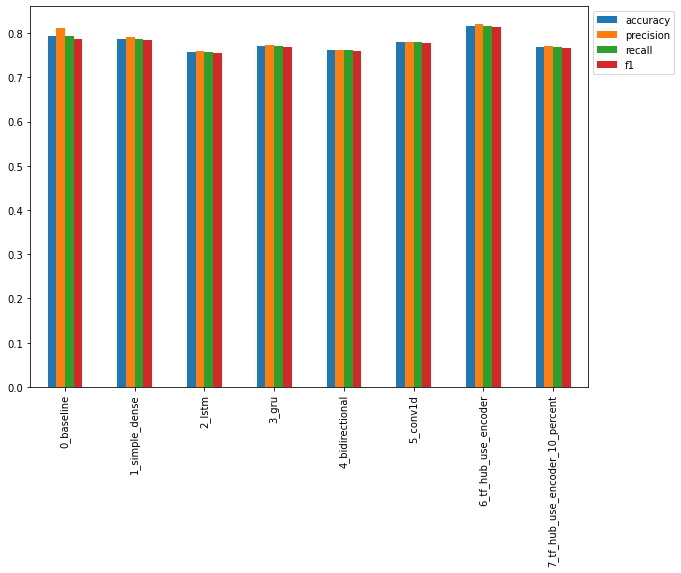

In [162]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0));

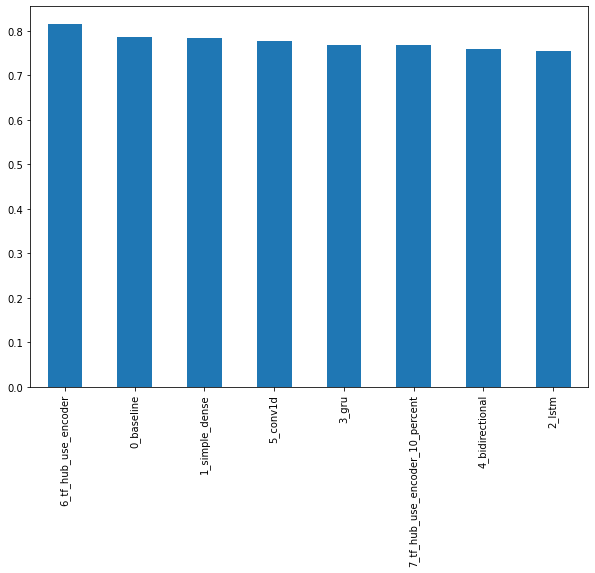

In [163]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10,7));

## Uploading our model training logs to TensorBoard.dev

In [ ]:
# View TensorBoard logs of transfer learning modellin experiments (plus all of our other models)
# Upload TensorBoard.dev records
!tensorboard dev upload --logdir ./model_logs/ \
  --name "NLP Modelling Experiments" \
  --description "Comparing multiple different types of model architectures on the Kaggle Tweet text classification dataset" \
  --one_shot # exit the uploader once uploading is done

Now I've ran the cell above, my modelling experiments are visable on TensorBoard.dev: https://tensorboard.dev/experiment/5ZYTKoZvTOKLcprYYBSn0w/

> 📖 **Resource:** TensorBoard is great for quickly tracking experiments but for larger scale experiments and a whole bunvh more tracking options, check out Weights & Biases: https://wandb.ai/site

In [ ]:
# If you need to remove previous experiments, you can do so using the following command
# !tensorboard dev delete --experiment_id EXPERIMENT_ID_TO_DELETE

In [ ]:
model

## Finding the most wrong examples

- If our best model still isn't perfect, what examples is it getting wrong?
- And of these wrong examples which ones is it getting *most* wrong (those will prediction probabilities closes to the opposite class)

For example if a sample should have a label of 0 but our model predicts a prediction probability of 0.999 (really close to 1) and vica versa

In [6]:
# Download a pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2021-10-07 21:24:13--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.128, 142.250.101.128, 142.250.141.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M   121MB/s    in 8.2s    

2021-10-07 21:24:22 (111 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.

In [7]:
import tensorflow as tf
from tensorflow.keras import layers
# Import previously trained model from Google Storage
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 9ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723122239112854, 0.8162729740142822]

In [8]:
# Make predictions with the loaded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [9]:
# Create DataFrame with validation sentences, validation labels and best performing model predictions + probabilities
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "pred_prob": tf.squeeze(model_6_pretrained_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [10]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


In [11]:
most_wrong.tail()

,text,target,pred,pred_prob
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


Target labels:
- `0` = not disaster
- `1` = disaster

In [12]:
 # Check the false positives (model predicted 1 when should've been 0)
 for row in most_wrong[:10].itertuples():
   _, text, target, pred, pred_prob = row
   print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
   print(f"Text:\n{text}\n")
   print("-----\n")

Target: 0, Pred: 1.0, Prob: 0.9101957082748413
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

-----

Target: 0, Pred: 1.0, Prob: 0.8769820928573608
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

-----

Target: 0, Pred: 1.0, Prob: 0.8523001670837402
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

-----

Target: 0, Pred: 1.0, Prob: 0.8354544639587402
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

-----

Target: 0, Pred: 1.0, Prob: 0.8272132873535156
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

-----

Target: 0, Pred: 1.0, Prob: 0.814815878868103
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!


In [23]:
 # Check the false negatives (model predicted 1 when should've been 0)
 for row in most_wrong[-10:].itertuples():
   _, text, target, pred, pred_prob = row
   print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
   print(f"Text:\n{text}\n")
   print("-----\n")

Target: 1, Pred: 0.0, Prob: 0.06730344146490097
Text:
@DavidVonderhaar At least you were sincere ??

-----

Target: 1, Pred: 0.0, Prob: 0.05507584288716316
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

-----

Target: 1, Pred: 0.0, Prob: 0.05460337549448013
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

-----

Target: 1, Pred: 0.0, Prob: 0.05459698289632797
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

-----

Target: 1, Pred: 0.0, Prob: 0.04963727295398712
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

-----

Target: 1, Pred: 0.0, Prob: 0.043918490409851074
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

-----

Target: 1, Pred: 0.0, Pro

In [24]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


## Making predictions on the test dataset

In [14]:
import random
# Making predictions on the test dataset and visualizing them
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample])) # our model expects a list as input
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("------\n")

Pred: 0, Prob: 0.1830405592918396
Text:
@mishavelgos @MattBacal8 @ComplexMag this is so accurate I can't even speak haha... Comparing hazard to harden is so true

------

Pred: 1, Prob: 0.5818614363670349
Text:
U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... https://t.co/lATVr8RZCK via @Change

------

Pred: 0, Prob: 0.19843491911888123
Text:
'I must not fear/Fear is the mindkiller/Fear is the little-death that brings total obliteration/I will face my fear' #Dune #BlacklivesMatter

------

Pred: 0, Prob: 0.1088269054889679
Text:
Actually if I don't see Hunter Hayes and Lady Antebellum perform Where it All Begins live I will be a very devastated person :-)

------

Pred: 0, Prob: 0.3061552941799164
Text:
Need a conquest server on CTE they're all Russian Squad Obliteration servers at the moment. Lame. But only 105 ping on Russian server. ??

------

Pred: 0, Prob: 0.08442676067352295
Text:
I had trouble breathing while listening to 

In [26]:
test_sample="The flood hit Kastamonu for the second time, transportation to some villages was cut off"
pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample])) # our model expects a list as input
pred = tf.round(pred_prob)
print(f"Pred: {int(pred)}, Prob: {pred_prob}")
print(f"Text:\n{test_sample}\n")

Pred: 1, Prob: 0.9150900840759277
Text:
The flood hit Kastamonu for the second time, transportation to some villages was cut off



## The speed/score tradeoff

In [27]:
# Let's make a function to measure the time of prediction
import time 
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples
  """
  start_time = time.perf_counter() # get start time 
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time - start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred

In [28]:
# Calculate TF Hub Sentence Encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model=model_6_pretrained,
                                                            samples=val_sentences)
model_6_total_pred_time, model_6_time_per_pred

(0.2218951489999199, 0.00029120098293952744)

In [33]:
# Calculate our basleine model times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.01536283999985244, 2.0161207348887716e-05)

In [36]:
# Get results for pretrained GS model
model_6_pretrained_results = calculate_results(y_true=val_labels,
                                               y_pred=model_6_pretrained_preds)
model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'f1': 0.8148082644367335,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651}

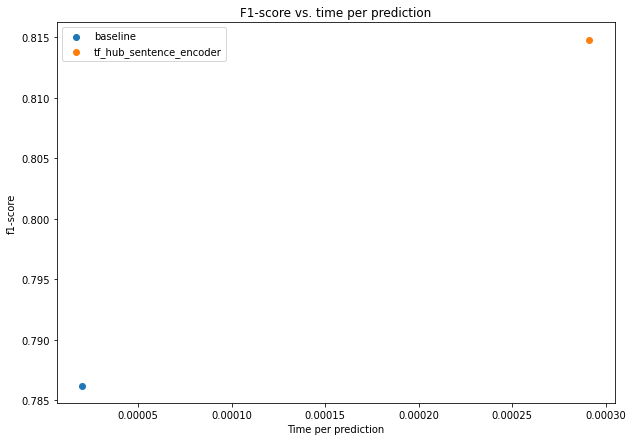

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_pretrained_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score vs. time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("f1-score");